In [69]:
import librosa
import librosa.display
import soundfile
from pydub import AudioSegment
import os, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [3]:
# Extract info from audio files
def extract_audio_features(file_name, mfcc, chroma, mel):
    """
    mfcc represents the short term power spectrum of the sound
    chroma is the pitch
    mel is the spectrogram frequency
    """
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma:
            fourier = np.abs(librosa.stft(X))
            
        # compile the three features into a result    
        result = np.array([])

        if mfcc:
            pwr_spec = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, pwr_spec)) # add to result
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=fourier, 
                                                        sr=sample_rate,
                                                        ).T, axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))
    return result

In [96]:
# Define the emotion labels in the RAVDESS dataset
emotions = {
    '01': 'neutral',
    '02': 'calm',    
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',    
    '08': 'surprised' 
    }
# we are looking at a subset of emotions of interest    
observed_emotions = ('calm', 'happy', 'fearful', 'disgust')

sexes = lambda x: 'Female' if x%2==0 else 'Male'


In [5]:
# Load the files in. 
# We needed the previous functions to make sense of the filename and info

def load_data(test_size=0.2):
    x,y, sex_label = [], [], []
    # use the glob library to parse through files with wildcard
    files = [file for file in glob.glob("..\data\Actor_*\*.wav")]
    for file in files:
        file_name=os.path.basename(file)
        file_attributes = file_name.split("-")

        emotion = emotions[file_attributes[2]]
        sex = sexes(int(file_attributes[6].split(".")[0]))

        if emotion not in observed_emotions:
            continue

        feature = extract_audio_features(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
        sex_label.append(sex)

    return train_test_split(np.array(x), y, test_size=test_size, random_state=11), sex_label


In [97]:
# Note this is a rather conservative split given the amount of data.
# First I will run it as is but then I want to train on more of the data 
# Could use data augmentation to beef it up.
# X_train, X_test, y_train, y_test = load_data(test_size=0.20)
data, sex_label = load_data(test_size=0.20)
X_train, X_test, y_train, y_test = data

In [98]:
print(type(X_train), type(y_test))
print('shapes of data:', (np.array(X_train).shape, np.array(X_test).shape, np.array(y_test).shape), np.shape(y_train))
print('The first number represents how many files, the second is how many feautures extracted' )

<class 'numpy.ndarray'> <class 'list'>
shapes of data: ((614, 180), (154, 180), (154,)) (614,)
The first number represents how many files, the second is how many feautures extracted


Text(0.5, 0, 'Time')

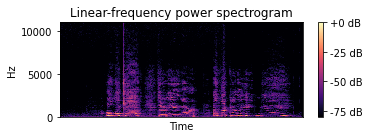

In [9]:
# Let's visualize a spectrogram
def vis_spec(audio_file):
    y, sr = librosa.load(path='..\inputs\\fearful-sample.wav', sr=None)
    plt.figure(figsize=(12, 8))

    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    plt.subplot(4, 2, 1)

    librosa.display.specshow(D, y_axis="linear")
    plt.colorbar(format='%+2.0f dB')
    plt.title('Linear-frequency power spectrogram')
    plt.xlabel('Time')



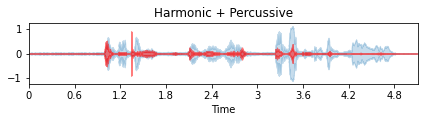

In [10]:
# Let's visualize harmonic and percussive components with transparency
y_harm, y_perc = librosa.effects.hpss(y)
plt.subplot(3, 1, 3)
librosa.display.waveplot(y_harm, sr=sr, alpha=0.25)
librosa.display.waveplot(y_perc, sr=sr, color='r', alpha=0.5)
plt.title('Harmonic + Percussive')
plt.tight_layout()

In [11]:
# The method shows here is from sklearn's neural network... could potentially try our own later
# Multi Layer Perceptron Classifier
model = MLPClassifier(alpha=0.01, batch_size=32, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500, verbose=True)


In [100]:
# Scale the data
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
# Fit the model
model.fit(X_train, y_train)

Iteration 1, loss = 1.33866467
Iteration 2, loss = 0.97125269
Iteration 3, loss = 0.81898664
Iteration 4, loss = 0.72617703
Iteration 5, loss = 0.65676851
Iteration 6, loss = 0.59885894
Iteration 7, loss = 0.55819857
Iteration 8, loss = 0.51810717
Iteration 9, loss = 0.48667963
Iteration 10, loss = 0.45330422
Iteration 11, loss = 0.41849858
Iteration 12, loss = 0.38219128
Iteration 13, loss = 0.35881606
Iteration 14, loss = 0.33836911
Iteration 15, loss = 0.31156242
Iteration 16, loss = 0.30533439
Iteration 17, loss = 0.29105078
Iteration 18, loss = 0.26701372
Iteration 19, loss = 0.24907644
Iteration 20, loss = 0.23308530
Iteration 21, loss = 0.21864265
Iteration 22, loss = 0.21160585
Iteration 23, loss = 0.20732272
Iteration 24, loss = 0.18829484
Iteration 25, loss = 0.18185081
Iteration 26, loss = 0.16875931
Iteration 27, loss = 0.16613473
Iteration 28, loss = 0.15771247
Iteration 29, loss = 0.15066959
Iteration 30, loss = 0.14485424
Iteration 31, loss = 0.13699927
Iteration 32, los

MLPClassifier(alpha=0.01, batch_size=32, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500, verbose=True)

In [101]:
y_pred = model.predict(X_test)
print('Accuracy:', round(accuracy_score(y_true=y_test, y_pred=y_pred), ndigits=3))

Accuracy: 0.766


In [149]:
# Attempted keras model from scratch. Pretty Good results
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
# Build a simple dense model with early stopping and softmax for categorical classification, remember we have 4 classes
keras_model = Sequential()
keras_model.add(Dense(180, input_shape=(180,), activation = 'relu'))
keras_model.add(Dropout(0.1))
keras_model.add(Dense(128, activation = 'relu'))
keras_model.add(Dropout(0.25))
keras_model.add(Dense(128, activation = 'relu'))
keras_model.add(Dropout(0.5))
keras_model.add(Dense(4, activation = 'softmax'))
keras_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [132]:
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train_encoded, 4)
y_test_encoded = to_categorical(y_test_encoded, 4)


In [151]:
history = keras_model.fit(X_train, y_train_encoded, batch_size=256, epochs=300, 
                    validation_data=(X_test, y_test_encoded),
                    callbacks=[early_stop])

Epoch 1/300
3/3 [==============================] - 0s 13ms/step - loss: 0.0357 - accuracy: 0.9919 - val_loss: 1.9779 - val_accuracy: 0.7468
Epoch 2/300
3/3 [==============================] - 0s 7ms/step - loss: 0.0429 - accuracy: 0.9886 - val_loss: 1.9131 - val_accuracy: 0.7532
Epoch 3/300
3/3 [==============================] - 0s 7ms/step - loss: 0.0950 - accuracy: 0.9886 - val_loss: 1.8907 - val_accuracy: 0.7597
Epoch 4/300
3/3 [==============================] - 0s 6ms/step - loss: 0.0514 - accuracy: 0.9805 - val_loss: 1.8834 - val_accuracy: 0.7597
Epoch 5/300
3/3 [==============================] - 0s 7ms/step - loss: 0.0513 - accuracy: 0.9853 - val_loss: 1.9078 - val_accuracy: 0.7403
Epoch 6/300
3/3 [==============================] - 0s 7ms/step - loss: 0.0455 - accuracy: 0.9821 - val_loss: 1.9740 - val_accuracy: 0.7403
Epoch 7/300
3/3 [==============================] - 0s 7ms/step - loss: 0.0467 - accuracy: 0.9902 - val_loss: 2.0583 - val_accuracy: 0.7273
Epoch 8/300
3/3 [=========

In [176]:
# Let's try reading in our own sample
path = 'C:\\Users\\jonma\\Programming\\speech-emotion\\inputs\\angry-sample.wav'
sound = AudioSegment.from_wav(path)
if sound.channels == 2:
    sound = sound.set_channels(1)
    sound.export(path, format="wav")

audio_sample = extract_audio_features(path, mfcc=True, chroma=True, mel=True)
audio_ready = ss.transform(np.array(audio_sample).reshape(1,-1))
model.predict(audio_ready)

array(['calm'], dtype='<U7')

In [177]:
le.inverse_transform(keras_model.predict_classes(audio_ready))

array(['calm'], dtype='<U7')

In [145]:
# Try for gender real quick
gender_model = MLPClassifier(alpha=0.01, batch_size=32, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500, verbose=True)
gender_model.fit(X_train, sex_label[:len(X_train)])


Iteration 1, loss = 0.82335715
Iteration 2, loss = 0.72111727
Iteration 3, loss = 0.64125270
Iteration 4, loss = 0.61235290
Iteration 5, loss = 0.59072222
Iteration 6, loss = 0.57007965
Iteration 7, loss = 0.55480649
Iteration 8, loss = 0.54540072
Iteration 9, loss = 0.52290695
Iteration 10, loss = 0.50966864
Iteration 11, loss = 0.50255328
Iteration 12, loss = 0.49254844
Iteration 13, loss = 0.48366958
Iteration 14, loss = 0.48659431
Iteration 15, loss = 0.45167390
Iteration 16, loss = 0.44273372
Iteration 17, loss = 0.43867756
Iteration 18, loss = 0.42394863
Iteration 19, loss = 0.41660305
Iteration 20, loss = 0.40786429
Iteration 21, loss = 0.38771618
Iteration 22, loss = 0.38332937
Iteration 23, loss = 0.38188579
Iteration 24, loss = 0.38439691
Iteration 25, loss = 0.37222937
Iteration 26, loss = 0.36326090
Iteration 27, loss = 0.34066610
Iteration 28, loss = 0.34287379
Iteration 29, loss = 0.34051469
Iteration 30, loss = 0.33144257
Iteration 31, loss = 0.31444225
Iteration 32, los

MLPClassifier(alpha=0.01, batch_size=32, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500, verbose=True)

In [148]:
# Wow, pure guessing
y_pred = gender_model.predict(X_test)
print('Accuracy:', round(accuracy_score(y_true=sex_label[len(X_train):], y_pred=y_pred), ndigits=3))

Accuracy: 0.513
